In [49]:
import pandas as pd
import nltk
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from tqdm import tqdm


#data = pd.read_csv("../data/drugsComTrain_raw.csv")
#data_test = pd.read_csv("../data/drugsComTest_raw.csv")

#data = pd.read_csv("../data/drugsComTrain_tokens.csv")
#data_test = pd.read_csv("../data/drugsComTest_tokens.csv")

In [2]:
from nltk.corpus import stopwords
#nltk.download("stopwords")
import re

s=set(stopwords.words('english'))
s.add("i'm")
s.add('like')
s.add("I've")
s.add('mg')

# Filters )(!- additionally compared to 4
def filter_the_review(review):
    # remove ""
    review = re.sub('\"', '', review)
    
    # replace &#39; -> this is equivlaent to '
    review = re.sub('&#039;', '\'', review)
    
    # remove .,; &quot
    review = re.sub('[.,;]', '', review)
    review = re.sub('&quot', '', review)
    
    #remove ) ( ! -
    #exclamation mark might be interesting, though
    review = re.sub('[)(!-]', '', review)
    
    
    # change to small letters
    review = review.lower()
    
    # remove numbers
    review = re.sub('[0-9]+','', review)
    
    # replace two spaces with one (if they exist somewhere)
    review = re.sub('  ', ' ', review)
    
    # remove the stopwords
    filtered = filter(lambda w: not w in s,review.split())
    
    list_words = list(filtered)
    string_review = " ".join(list_words)
    

    return string_review

In [3]:
#Old preprocessing steps

data["review_t"] = data["review"].transform(lambda x: nltk.word_tokenize(filter_the_review(x)))
data_test["review_t"] = data_test["review"].transform(lambda x: nltk.word_tokenize(filter_the_review(x)))


review = data["review"].iloc[3]
print(review)
print(type(review))
tokens = data["review_t"].iloc[3]
print(tokens)
print(type(tokens))


"This is my first time using any form of birth control. I&#039;m glad I went with the patch, I have been on it for 8 months. At first It decreased my libido but that subsided. The only downside is that it made my periods longer (5-6 days to be exact) I used to only have periods for 3-4 days max also made my cramps intense for the first two days of my period, I never had cramps before using birth control. Other than that in happy with the patch"
<class 'str'>
['first', 'time', 'using', 'form', 'birth', 'control', 'glad', 'went', 'patch', 'months', 'first', 'decreased', 'libido', 'subsided', 'downside', 'made', 'periods', 'longer', 'days', 'exact', 'used', 'periods', 'days', 'max', 'also', 'made', 'cramps', 'intense', 'first', 'two', 'days', 'period', 'never', 'cramps', 'using', 'birth', 'control', 'happy', 'patch']
<class 'list'>


In [4]:
#data.to_csv("../data/drugsComTrain_tokens.csv")
#data_test.to_csv("../data/drugsComTest_tokens.csv")
data.info()

### Look at most common words in positive/negative reviews to formulate hypothesis
### ...for specific drugs

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161297 entries, 0 to 161296
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   uniqueID     161297 non-null  int64 
 1   drugName     161297 non-null  object
 2   condition    160398 non-null  object
 3   review       161297 non-null  object
 4   rating       161297 non-null  int64 
 5   date         161297 non-null  object
 6   usefulCount  161297 non-null  int64 
 7   review_t     161297 non-null  object
dtypes: int64(3), object(5)
memory usage: 9.8+ MB


In [5]:
def get_freq_dist(df, conditions=True, ratings=range(1, 11)):
    if conditions:
        filt_l = (df["condition"].isin(conditions))
    df = df[filt_l & df["rating"].isin(ratings)]
    reviews = df["review_t"].sum()
    return nltk.FreqDist(reviews)


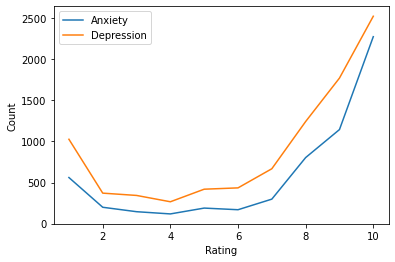

In [6]:
# Prediction of ratings depends on unconditional distribution of ratings
data_anx = data[data["condition"]=="Anxiety"]
data_depr = data[data["condition"]=="Depression"]
rating_counts_anx = [data_anx[data_anx["rating"]==i].shape[0] for i in range(1,11)]
rating_counts_depr = [data_depr[data_depr["rating"]==i].shape[0] for i in range(1,11)]

plt.plot(range(1,11), rating_counts_anx, label="Anxiety")
plt.plot(range(1,11), rating_counts_depr, label="Depression")
plt.legend()
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

In [7]:
# -> naively high and - to a lesser degree - lower ratings will be predicted preferentially

freq_dist_anx = get_freq_dist(data, ["Anxiety"])
freq_dist_depr = get_freq_dist(data, ["Depression"])

In [8]:
n = 50
#maybe compare randomly selected words as inputs vs most common words?
words_anx = [w for w, _ in freq_dist_anx.most_common(n)]
words_depr = [w for w, _ in freq_dist_depr.most_common(n)]
words_depr

['depression',
 'feel',
 'side',
 'taking',
 'effects',
 'anxiety',
 'i',
 'years',
 'day',
 'started',
 'life',
 "'ve",
 'first',
 'weeks',
 'medication',
 'months',
 'better',
 'felt',
 'take',
 'time',
 'days',
 'get',
 'back',
 'much',
 'would',
 'also',
 'doctor',
 'week',
 'sleep',
 'really',
 'medicine',
 'good',
 'feeling',
 'still',
 'one',
 'weight',
 'tried',
 'took',
 'dose',
 'work',
 'went',
 'drug',
 'made',
 'well',
 'night',
 'zoloft',
 'wellbutrin',
 'ago',
 'great',
 'bad']

In [27]:
def get_count_vector(row, words):
    counts = [nltk.FreqDist(row["review_t"]).get(w) for w in words]
    counts = [0 if count is None else count for count in counts]
    return counts

# Collect word count vectors for words in df and corresponding ratings
def get_count_vectors(df, words, target_val = "rating"):
    word_vectors=[]
    target_vals=[]
    for _, row in df.iterrows():
        word_vectors.append(get_count_vector(row, words))
        target_vals.append(row[target_val])
    word_vectors = np.array(word_vectors)
    target_vals = np.array(target_vals)
    return word_vectors, target_vals

In [28]:
X_depr, y_depr = get_count_vectors(data_depr, words_depr)
print(X_depr)
print(y_depr)

[[1 1 2 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 1 0]
 [1 0 1 ... 0 0 0]
 [1 1 0 ... 0 0 0]]
[10  8  4 ... 10  3  2]


In [21]:
model_depr = LinearRegression().fit(X_depr, y_depr)
sample_nr = range(10, 50)
samples = [data_depr.iloc[i] for i in sample_nr]
inputs = [get_count_vector(sample, words_depr) for sample in samples]
true_labels = [sample["rating"] for sample in samples]

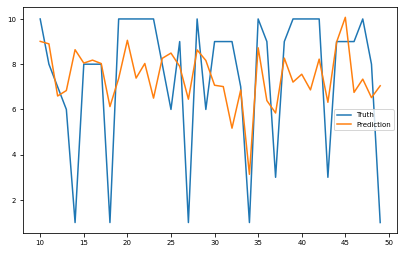

In [22]:
plt.plot(sample_nr, true_labels, label="Truth")
plt.plot(sample_nr, model_depr.predict(inputs), label="Prediction")
plt.legend()
plt.show()

In [32]:
# Improvement of prediction with number of considered words
# Score used by sklearn mitigates issue of prior distribution of ratings
data_test_depr = data_test[data_test["condition"]=="Depression"]
X_test_depr, y_test_depr = get_count_vectors(data_test_depr, words_depr)
dim_inputs = range(1,51)
models_depr = [LinearRegression().fit(X_depr[:,:d], y_depr) for d in dim_inputs]
scores_test = [model.score(X_test_depr[:,:d], y_test_depr) for model, d in zip(models_depr, dim_inputs)]
scores_train = [model.score(X_depr[:,:d], y_depr) for model, d in zip(models_depr, dim_inputs)]

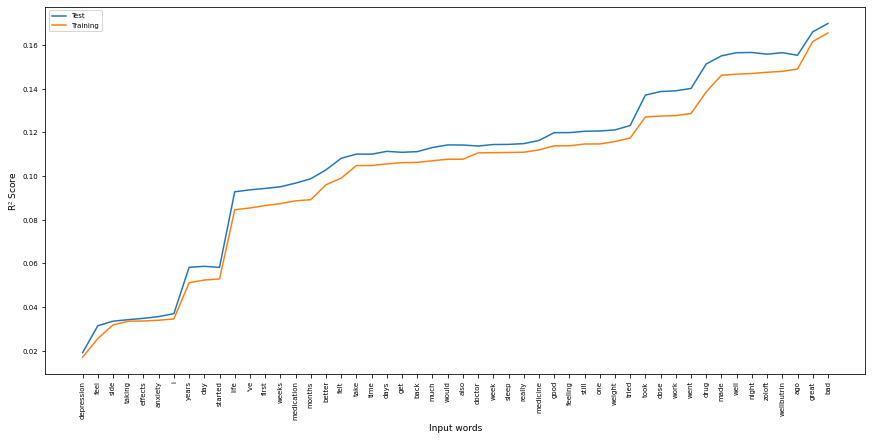

In [33]:
# Here we can somewhat see which words help more in predicting rating
# note this is 

plt.figure(figsize=(12,6))
plt.plot(words_depr, scores_test, label="Test")
plt.plot(words_depr, scores_train, label="Training")
plt.xticks(rotation=90)
plt.xlabel("Input words")
plt.ylabel("R$^2$ Score")
plt.legend()
plt.show()

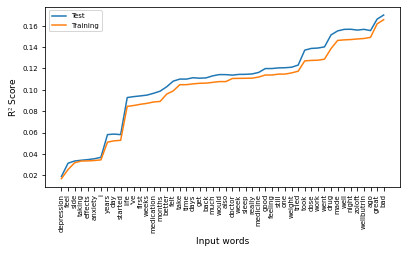

In [47]:
from tueplots import bundles
plt.rcParams.update(bundles.neurips2021(usetex=False, ncols=1, nrows=1))
#plt.figure(figsize=(12,6))
plt.plot(words_depr, scores_test, label="Test")
plt.plot(words_depr, scores_train, label="Training")
plt.xticks(rotation=90)
plt.xlabel("Input words")
plt.ylabel("R$^2$ Score")
plt.legend()

plt.savefig("../docs/pdfs/words_vs_score.pdf")
plt.show()


In [52]:
def models_over_acc_inputs(words, df_train=None, df_test=None, matrices=None, regressor = LinearRegression, target_val="rating", ax=None):
    if matrices:
        X_train, y_train, X_test, y_test = matrices
    else:
        X_train, y_train = get_count_vectors(df_train, words, target_val=target_val)
        X_test, y_test = get_count_vectors(df_test, words, target_val=target_val)
    input_dims = range(1, len(words)+1)
    models = [regressor().fit(X_train[:,:d], y_train) for d in input_dims]
    scores_train = [model.score(X_train[:,:d], y_train) for model, d in zip(models, input_dims)]
    scores_test = [model.score(X_test[:,:d], y_test) for model, d in zip(models, input_dims)]
    #Option to plot automatically
    if ax:
        ax.plot(words, scores_train, label="Training")
        ax.plot(words, scores_test, label="Test")
        ax.set_xticklabels(words, rotation=90)
        ax.set_xlabel("Input words")
        ax.set_ylabel("R$^2$ Score")
    return models, scores_train, scores_test

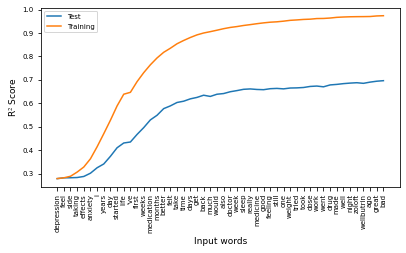

In [55]:
matrices = (X_depr, y_depr, X_test_depr, y_test_depr)
model_tree, scores_train_tree, scores_test_tree = models_over_acc_inputs(words_depr, matrices=matrices, regressor=DecisionTreeClassifier)


In [ ]:
words_depr_rev = list(reversed(words_depr))
_, scores_train_rev, scores_test_rev = models_over_acc_inputs(words_depr_rev, df_train=data_depr, df_test=data_test_depr)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 8))
ax1.plot(words_depr, scores_test, label="Linear: Test")
ax1.plot(words_depr, scores_train, label="Linear: Training")
ax2.plot(words_depr_rev, scores_test_rev, label="Rev Linear: Test")
ax2.plot(words_depr_rev, scores_train_rev, label="Rev Linear: Training")
plt.xticks(rotation=90)
plt.xlabel("Input words")
plt.ylabel("R$^2$ Score")
plt.legend()
#plt.savefig("../docs/pdfs/words_vs_score_dectree.pdf")

plt.show()


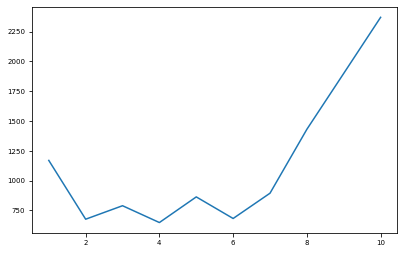

In [60]:
#suspected "weigth" to be more common with low rankings
w = "weight"
counts = []
for i in range(1,11):
    counts.append(get_freq_dist(data, ["Birth Control"], [i]).get("weight"))
plt.plot(range(1, 11), counts)
plt.show()

In [62]:
words_depr.reverse()
#get_freq_dist(data, ["Back Pain"], [1]).most_common()

In [102]:
get_freq_dist(data, ratings=[10]).most_common()

[('!', 30569),
 ('years', 15019),
 ('day', 13891),
 ('i', 13886),
 ('side', 13494),
 ('take', 11798),
 (')', 11629),
 ('effects', 11383),
 ('(', 11057),
 ("'ve", 11052),
 ('taking', 11004),
 ('first', 10729),
 ('pain', 10547),
 ('life', 9916),
 ('started', 9853),
 ('get', 9520),
 ('time', 9327),
 ('feel', 9041),
 ('days', 9011),
 ('months', 8879),
 ('would', 8231),
 ('back', 7711),
 ('one', 7687),
 ('pill', 7608),
 ('period', 7022),
 ('doctor', 6972),
 ('week', 6906),
 ('since', 6884),
 ('took', 6831),
 ('medication', 6795),
 ('weight', 6791),
 ('weeks', 6695),
 ('anxiety', 6608),
 ('got', 6514),
 ('great', 6091),
 ('-', 6054),
 ('medicine', 5960),
 ('also', 5918),
 ('tried', 5873),
 ('much', 5794),
 ('works', 5690),
 ('went', 5611),
 ('really', 5595),
 ('work', 5489),
 ('better', 5420),
 ('never', 5404),
 ('month', 5393),
 ('every', 5320),
 ('bad', 5291),
 ('two', 4957),
 ('good', 4851),
 ('even', 4807),
 ('control', 4803),
 ('well', 4790),
 ('year', 4720),
 ('still', 4694),
 ('worked

In [103]:
get_freq_dist(data, ratings=[1]).most_common()

[('!', 14070),
 ('i', 5802),
 ('day', 5540),
 ('taking', 5473),
 ('pain', 5085),
 ('months', 4660),
 ("'ve", 4492),
 ('started', 4467),
 ('get', 4348),
 ('days', 4295),
 ('took', 4283),
 ('never', 4221),
 ('would', 4202),
 ('pill', 4151),
 ('time', 3914),
 ('first', 3908),
 ('take', 3898),
 ('side', 3864),
 ('(', 3826),
 (')', 3670),
 ('got', 3623),
 ('doctor', 3439),
 ('one', 3406),
 ('weeks', 3363),
 ('effects', 3322),
 ('back', 3319),
 ('medication', 3186),
 ('feel', 3119),
 ('felt', 3034),
 ('still', 3034),
 ('bad', 2969),
 ('week', 2963),
 ('month', 2861),
 ('period', 2776),
 ('years', 2769),
 ('even', 2765),
 ('made', 2762),
 ('bleeding', 2719),
 ('drug', 2674),
 ('went', 2656),
 ('control', 2613),
 ('ever', 2590),
 ('worse', 2563),
 ('also', 2543),
 ('horrible', 2509),
 ('&', 2378),
 ('birth', 2376),
 ('anxiety', 2348),
 ('since', 2343),
 ('work', 2307),
 ('worst', 2286),
 ('weight', 2160),
 ('life', 2138),
 ('two', 2135),
 ('going', 2114),
 ('go', 2108),
 ('could', 2102),
 ('se

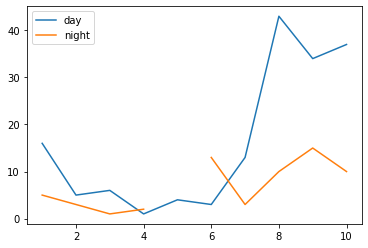

In [108]:
# do people doing good/bad with back pain speak more of day/night?
counts_day = []
counts_night = []
for i in range(1,11):
    freq_Dist = get_freq_dist(data, ["Back Pain"], [i])
    counts_day.append(freq_Dist.get("day"))
    counts_night.append(freq_Dist.get("night"))
plt.plot(range(1, 11), counts_day, label="day")
plt.plot(range(1, 11), counts_night, label="night")
plt.legend()
plt.show()

In [113]:
get_freq_dist(data, conditions=["Anxiety"], ratings=[1]).most_common()

[('anxiety', 518),
 ('!', 335),
 ('taking', 251),
 ('day', 221),
 ('took', 189),
 ('take', 160),
 ('medication', 154),
 ('panic', 150),
 ('drug', 145),
 ('made', 140),
 ('feel', 134),
 ('would', 133),
 ('started', 132),
 ('felt', 129),
 ('effects', 124),
 ('side', 122),
 ('get', 120),
 (')', 118),
 ('(', 117),
 ('doctor', 116),
 ('prescribed', 115),
 ('time', 115),
 ('worse', 112),
 ('dose', 107),
 ('attacks', 106),
 ('first', 106),
 ('weeks', 103),
 ('work', 100),
 ('help', 98),
 ('i', 98),
 ('days', 97),
 ('one', 95),
 ('bad', 90),
 ('even', 90),
 ('months', 87),
 ('years', 86),
 ('never', 86),
 ('medicine', 83),
 ('also', 83),
 ('night', 83),
 ('still', 82),
 ('horrible', 78),
 ('could', 78),
 ('feeling', 76),
 ('buspar', 76),
 ('sleep', 76),
 ('got', 72),
 ('hours', 71),
 ('pill', 71),
 ('xanax', 71),
 ('ever', 70),
 ("'ve", 70),
 ('life', 69),
 ('withdrawal', 68),
 ('went', 68),
 ('stop', 68),
 ('back', 67),
 ('nothing', 67),
 ('week', 67),
 ('put', 66),
 ('severe', 65),
 ('experi

In [114]:
get_freq_dist(data, conditions=["Anxiety"], ratings=[10]).most_common()

[('anxiety', 2598),
 ('take', 1194),
 ('!', 1155),
 ('life', 1074),
 ('day', 905),
 ('feel', 871),
 ('years', 841),
 ('panic', 786),
 ('taking', 718),
 ('i', 656),
 ('side', 644),
 ('xanax', 640),
 (')', 601),
 ('attacks', 590),
 ('(', 579),
 ('medication', 572),
 ('effects', 567),
 ('get', 540),
 ("'ve", 525),
 ('would', 524),
 ('medicine', 517),
 ('started', 512),
 ('doctor', 470),
 ('lexapro', 455),
 ('better', 455),
 ('first', 454),
 ('time', 448),
 ('prescribed', 441),
 ('much', 429),
 ('back', 425),
 ('sleep', 424),
 ('works', 402),
 ('depression', 388),
 ('great', 388),
 ('really', 378),
 ('felt', 377),
 ('work', 374),
 ('one', 370),
 ('also', 368),
 ('weeks', 356),
 ('days', 356),
 ('tried', 343),
 ('bad', 332),
 ('months', 324),
 ('without', 322),
 ('helped', 318),
 ('klonopin', 312),
 ('drug', 310),
 ('took', 309),
 ('-', 301),
 ('night', 300),
 ('dose', 296),
 ('never', 293),
 ('go', 282),
 ('since', 282),
 ('severe', 281),
 ('even', 275),
 ('well', 270),
 ('going', 266),
 (

In [24]:
depr_1 = get_freq_dist(data, conditions=["Depression"], ratings=[1])
depr_1.most_common(20).

AttributeError: 'list' object has no attribute 'values'

In [139]:
depr_10 = get_freq_dist(data, conditions=["Depression"], ratings=[10])
depr_10.most_common(20)

[('depression', 1766),
 ('!', 1430),
 ('life', 1328),
 ('feel', 1294),
 ('years', 1193),
 ('side', 1112),
 ('anxiety', 996),
 ('i', 983),
 ('effects', 975),
 ('taking', 946),
 ('day', 817),
 (')', 789),
 ('take', 759),
 ("'ve", 758),
 ('started', 755),
 ('first', 752),
 ('(', 742),
 ('better', 732),
 ('medication', 683),
 ('time', 658)]

In [21]:
depr_10_minus_1 = depr_10 -depr_1
depr_10_minus_1
depr_10_minus_1.most_common().values()

## Normalize with overall text length
## Count x (most common) words -> rating  linear/quadratic regression
## How does loss change with increasing x?
## Use subtract method
## "Years", "Months", "Days" -> Ratings

NameError: name 'depr_10' is not defined

In [47]:
#For dataframe of conditions and drugs return 
def word_count_matrix(df, n, conditions=None, drugs=None):
    
    filt_1 = True
    filt_2 = True
    if conditions:
        filt_1 = df["condition"].isin(conditions)
    if drugs:
        filt_2 = df["drugName"].isin(drugs)
    df = df[filt_1 & filt_2]
    freq_dict = nltk.FreqDist(df["review_t"].sum())
    freq_dict.plot()
    n_most_common = [word for word, _ in freq_dict.most_common(n)]
    word_counts=[]
    ratings=[]
    for i in range(1, 11):
        word_counts.append([nltk.FreqDist(df[df["rating"]==i]["review_t"].sum()).get(key) for key in n_most_common])
    return word_counts, ratings, n_most_common

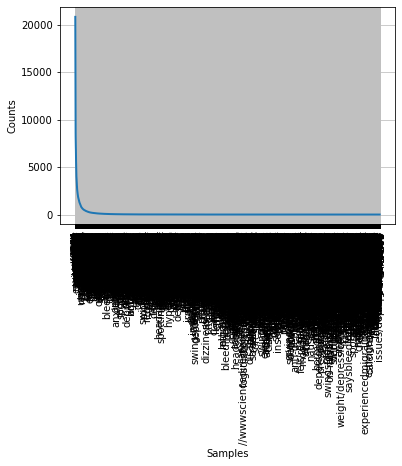

([[4144, 2523, 1890, 2106],
  [1481, 1399, 1114, 1137],
  [1202, 1474, 1152, 1213],
  [879, 1178, 983, 931],
  [1048, 1495, 1372, 1265],
  [533, 955, 1012, 818],
  [911, 1511, 1395, 1220],
  [1780, 2489, 2515, 1999],
  [3197, 3198, 3197, 2606],
  [5640, 3660, 3819, 3049]],
 ['!', 'i', 'period', "'ve"])

In [48]:
word_counts_for_ratings(data, 4, conditions=["Birth Control"])